In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from plotnine import ggplot, aes, geom_line, facet_wrap, theme_bw, theme, scale_x_continuous, element_blank, labs
from keras import regularizers

import re
import os
import sys

In [157]:
from google.colab import userdata
accessToken = userdata.get('AccessToken')

# accesses the github dataset by cloning the repository and downloading its contents
token = accessToken
repo_url = f"https://{token}@github.com/SleepDeprived3/Bias-in-Emotion-Recognition.git"
!git clone {repo_url}

fatal: destination path 'Bias-in-Emotion-Recognition' already exists and is not an empty directory.


## Experiment 1

##Loading and Cleaning the Data

In [3]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV")

path = []
id = []
phrase = []
emotion = []
intensity = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  path.append(item_name)
  filtered_name = item_name.removesuffix(".wav")
  structure = filtered_name.split("_")
  if (len(structure) == 4):
    id.append(structure[0])
    phrase.append(structure[1])
    emotion.append(structure[2])
    intensity.append(structure[3])

# creates a pandas dataframe using the previously created variable lists
crema_d_df = pd.DataFrame(zip(path, id, phrase, emotion, intensity))
crema_d_df.columns = ["path", "id", "phrase", "emotion", "intensity"]
crema_d_df

,path,id,phrase,emotion,intensity
0,1018_DFA_HAP_XX.wav,1018,DFA,HAP,XX
1,1063_TAI_FEA_XX.wav,1063,TAI,FEA,XX
2,1049_IEO_SAD_HI.wav,1049,IEO,SAD,HI
3,1040_IWW_NEU_XX.wav,1040,IWW,NEU,XX
4,1075_DFA_ANG_XX.wav,1075,DFA,ANG,XX
...,...,...,...,...,...
7437,1040_TAI_DIS_XX.wav,1040,TAI,DIS,XX
7438,1086_IEO_HAP_MD.wav,1086,IEO,HAP,MD
7439,1035_TAI_HAP_XX.wav,1035,TAI,HAP,XX
7440,1020_IOM_NEU_XX.wav,1020,IOM,NEU,XX


# Loading in Demographics Data

In [4]:
demog_df = pd.read_csv('/content/Bias-in-Emotion-Recognition/data/Crema-D/VideoDemographics.csv')
demog_df

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
4,1005,29,Male,African American,Not Hispanic
...,...,...,...,...,...
86,1087,62,Male,Caucasian,Not Hispanic
87,1088,23,Male,African American,Not Hispanic
88,1089,24,Female,Caucasian,Not Hispanic
89,1090,50,Male,Asian,Not Hispanic


**Checking Actor IDs Match**



In [5]:
demog_df['ActorID'] = demog_df['ActorID'].astype(str)
crema_d_df['ActorID'] = crema_d_df['id'].astype(str)

**Merge demographics info into parec dataframe**

In [6]:
df = crema_d_df.merge(demog_df, on='ActorID')
df = df.drop(columns=["id"])
df.head()

,path,phrase,emotion,intensity,ActorID,Age,Sex,Race,Ethnicity
0,1018_DFA_HAP_XX.wav,DFA,HAP,XX,1018,25,Female,Caucasian,Hispanic
1,1063_TAI_FEA_XX.wav,TAI,FEA,XX,1063,33,Female,African American,Not Hispanic
2,1049_IEO_SAD_HI.wav,IEO,SAD,HI,1049,25,Female,Caucasian,Hispanic
3,1040_IWW_NEU_XX.wav,IWW,NEU,XX,1040,42,Male,Caucasian,Not Hispanic
4,1075_DFA_ANG_XX.wav,DFA,ANG,XX,1075,40,Female,Caucasian,Not Hispanic



**Training and Testing**

In [7]:
features = ["Age", "Sex", "Race"]
X = df[features]
y = df["emotion"]

train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train, X_test = train[features], test[features]
y_train, y_test = train["emotion"], test["emotion"]


**Summary Tables**

In [8]:
age_summary = test.groupby("emotion")["Age"].mean()
age_summary

,Age
emotion,
ANG,35.785156
DIS,35.961240
FEA,35.396887
HAP,37.472574
NEU,36.346320
SAD,35.688000


In [9]:
gender_summary = test.groupby(["emotion", "Sex"]).size().unstack(fill_value=0)
gender_summary

Sex,Female,Male
emotion,,
ANG,122,134
DIS,117,141
FEA,130,127
HAP,117,120
NEU,110,121
SAD,110,140


In [10]:
race_summary = test.groupby(["emotion", "Race"]).size().unstack(fill_value=0)
race_summary

Race,African American,Asian,Caucasian,Unknown
emotion,,,,
ANG,59,24,169,4
DIS,75,13,165,5
FEA,50,18,186,3
HAP,55,20,161,1
NEU,52,23,154,2
SAD,65,20,160,5


**Plots**

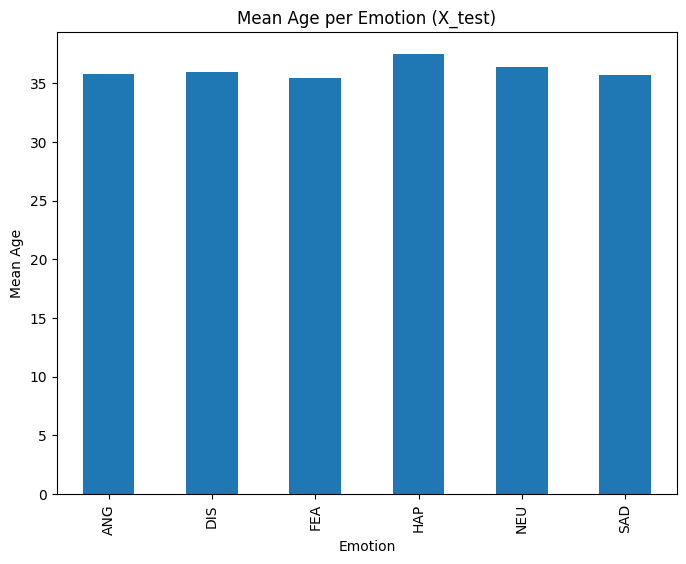

In [11]:
## Age distribution per emotion
plt.figure(figsize=(8,6))
test.groupby("emotion")["Age"].mean().plot(kind="bar")
plt.title("Mean Age per Emotion (X_test)")
plt.ylabel("Mean Age")
plt.xlabel("Emotion")
plt.show()

<Figure size 1000x600 with 0 Axes>

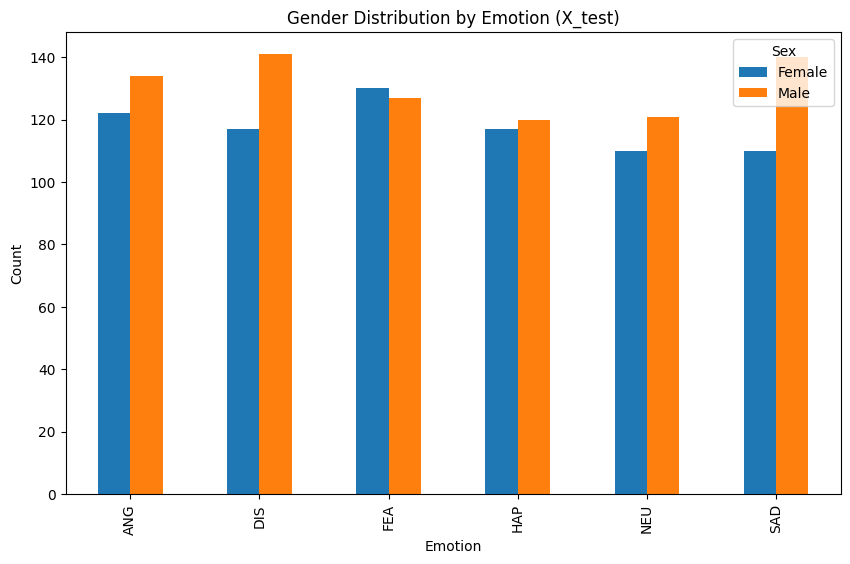

In [12]:
## Sex distribution per emotion
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Sex"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Gender Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

<Figure size 1000x600 with 0 Axes>

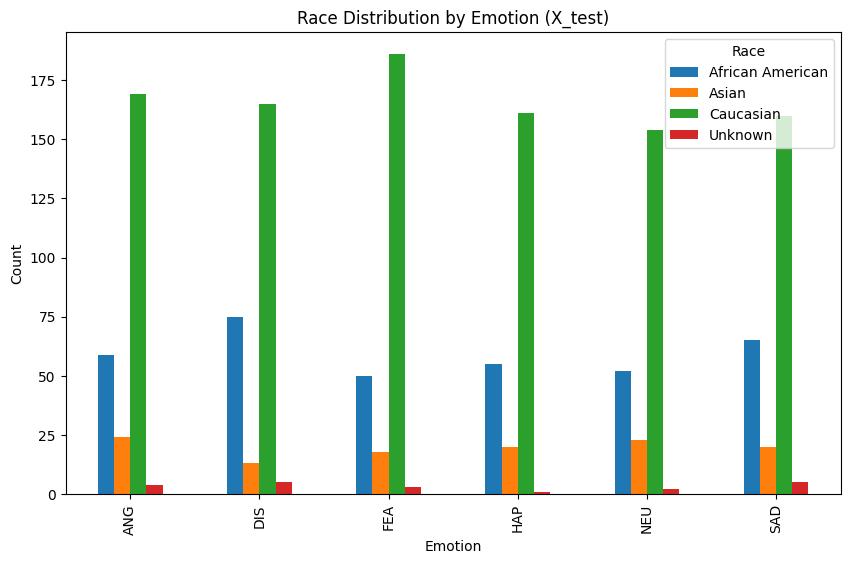

In [13]:
## Race distribution per emotion
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Race"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Race Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [14]:
my_num_mfcc=40  # typical number of mfcc features
my_n_fft=2048  # default audio sampling rate
my_hop_length=512  # default hop length value (256 if you want tailored to speech)
my_sample_rate = 22050  # default sampling rate (in Hz)

def extract_features(filename):
  y, sr = librosa.load(filename, sr=my_sample_rate)

  # turning audio data into Mel-Frequency Cepstral Coefficient features (which represent the power
  # spectra of sound) using the librosa library
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=my_num_mfcc, n_fft=my_n_fft, hop_length=my_hop_length).T
  return mfcc

extracted_features = []

path_prefix = "/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV/"

# creating features for each audio file in the dataset
for file_row in range(len(crema_d_df)):
  extracted_features.append(extract_features(path_prefix + crema_d_df.iloc[file_row, 0]))

extracted_features_padded = keras.preprocessing.sequence.pad_sequences(extracted_features)

In [15]:
# creating an LSTM model (test)
input = keras.layers.Input((None, extracted_features_padded.shape[2]))

lstm1 = keras.layers.LSTM(250, return_sequences=True)(input)
lstm2 = keras.layers.LSTM(250, return_sequences=False)(lstm1)

dense1 = keras.layers.Dense(100, kernel_regularizer=regularizers.l2(), activation="relu")(lstm2)
dropout1 = keras.layers.Dropout(0.3)(dense1)

dense2 = keras.layers.Dense(80, kernel_regularizer=regularizers.l2(), activation="relu")(dropout1)

output = keras.layers.Dense(crema_d_df['emotion'].nunique(), activation="softmax")(dense2)

lstm_emotion_identification_model = keras.Model(inputs=input, outputs=output)
lstm_emotion_identification_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 250)      │       291,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,666 (3.15 MB)

 Trainable params: 825,666 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
lstm_emotion_identification_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.CategoricalCrossentropy(),
  metrics = [keras.metrics.CategoricalAccuracy()]
)

In [17]:
# setting up X variables
X = extracted_features_padded

# allowing
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(crema_d_df['emotion'])

# one-hot encoding y_variables
y = tf.keras.utils.to_categorical(y_encoded, crema_d_df['emotion'].nunique())

In [18]:
# model fitting
keras.backend.clear_session()
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)
fit_model = lstm_emotion_identification_model.fit(X, y, validation_split=0.2, epochs=40, batch_size=15, shuffle=True, callbacks=[early_stopping_callback])

Epoch 1/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - categorical_accuracy: 0.2953 - loss: 2.6745 - val_categorical_accuracy: 0.3667 - val_loss: 1.6279
Epoch 2/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3858 - loss: 1.5941 - val_categorical_accuracy: 0.4171 - val_loss: 1.5264
Epoch 3/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3732 - loss: 1.5387 - val_categorical_accuracy: 0.4050 - val_loss: 1.4761
Epoch 4/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3872 - loss: 1.5051 - val_categorical_accuracy: 0.4177 - val_loss: 1.4631
Epoch 5/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.4053 - loss: 1.4736 - val_categorical_accuracy: 0.4110 - val_loss: 1.4483
Epoch 6/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.4086 - loss: 1.4628 - val_categorical_accuracy: 0.4171 - val_loss: 1.4398
Epoch 7/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.41

In [19]:
def plot_fit_history(history):
  df = pd.DataFrame(history.history)
  df['epoch'] = np.arange(len(df))

  # Reshape the dataframe to long format
  df_longer = df.melt(id_vars=['epoch'], var_name="measure", value_name="value")

  # Extract measure name and data type (train or validation)
  df_longer['data_type'] = df_longer['measure'].apply(lambda x: 'validation' if x.startswith('val_') else 'training')
  df_longer['measure'] = df_longer['measure'].apply(lambda x: re.sub('val_', '', x))

  return (ggplot(df_longer, mapping=aes(x="epoch", y="value", color="data_type"))+
   geom_line()+
   scale_x_continuous(breaks=np.arange(0, len(df)))+
   facet_wrap('~measure', scales='free_y')+
   labs(x = "Epoch", y="", color="Dataset")+
   theme_bw()+
   theme(panel_grid=element_blank()))

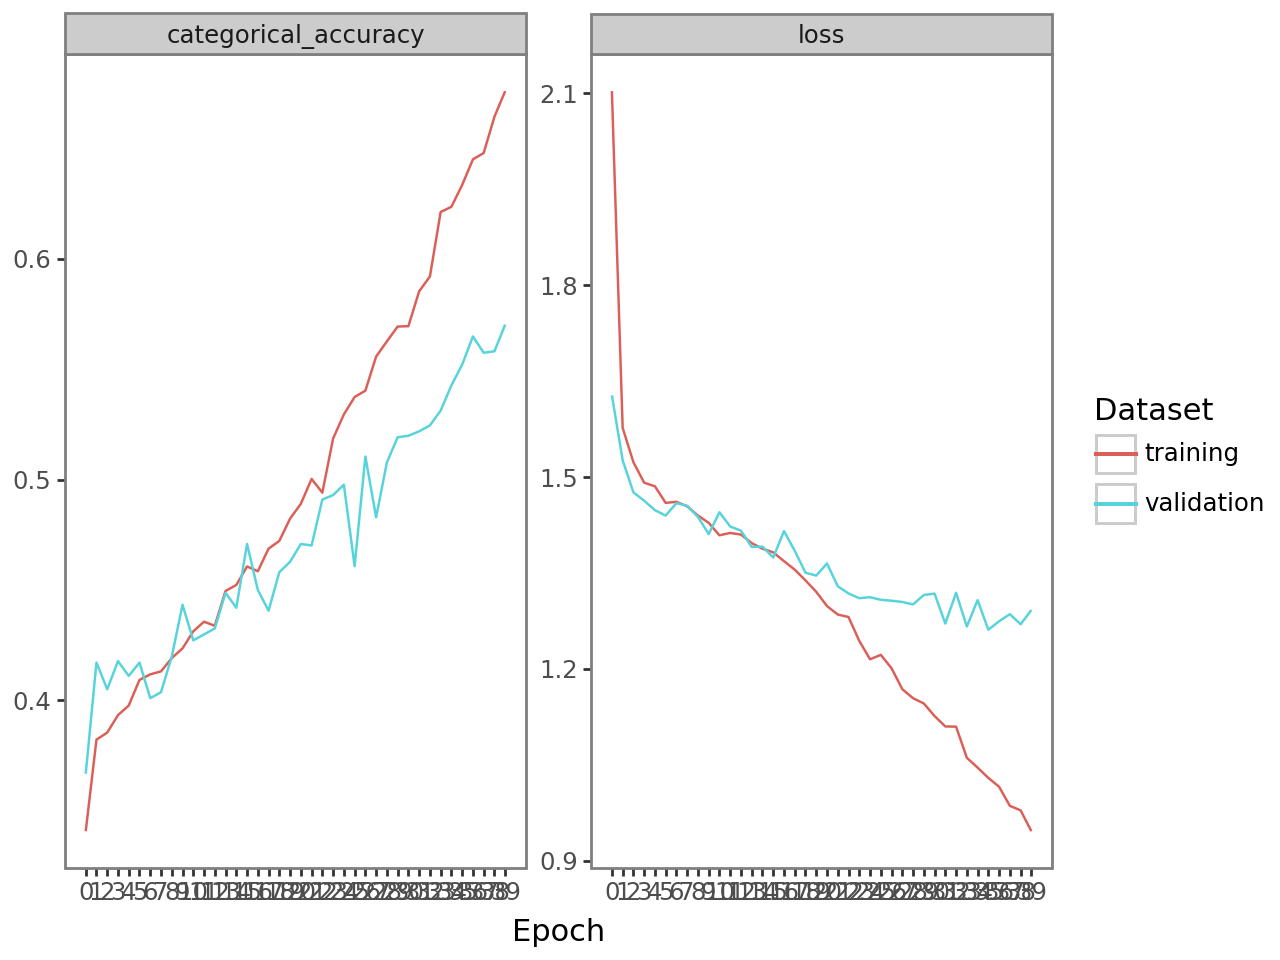

In [20]:
plot_fit_history(fit_model)

**Speech Accent Archive Data**

In [21]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings")

ssa_path = []
ssa_accent = []
ssa_number = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  ssa_path.append(item_name)
  filtered_name = item_name.removesuffix(".mp3")
  accent_string = ""
  number_string = ''
  for character in filtered_name:
    if character.isdigit():
      number_string = number_string + character
    else:
      accent_string = accent_string + character
  ssa_accent.append(accent_string)
  ssa_number.append(number_string)

# creates a pandas dataframe using the previously created variable lists
ssa_df = pd.DataFrame(zip(ssa_path, ssa_accent, ssa_number))
ssa_df.columns = ["path", "accent", "number"]
ssa_df

,path,accent,number
0,spanish28.mp3,spanish,28
1,german7.mp3,german,7
2,kanuri1.mp3,kanuri,1
3,english262.mp3,english,262
4,polish13.mp3,polish,13
...,...,...,...
2133,english546.mp3,english,546
2134,german8.mp3,german,8
2135,english88.mp3,english,88
2136,spanish100.mp3,spanish,100


In [22]:
ssa_extracted_features = []

path_prefix = "/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings/"

# creating features for each audio file in the dataset
for file_row in range(len(ssa_df)):
  ssa_extracted_features.append(extract_features(path_prefix + ssa_df.iloc[file_row, 0]))

ssa_extracted_features_padded = keras.preprocessing.sequence.pad_sequences(ssa_extracted_features)

In [23]:
ssa_prediction = lstm_emotion_identification_model.predict(ssa_extracted_features_padded)

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step


In [24]:
emotion_predictions = []

for file_row in range(len(ssa_prediction)):
  ssa_prediction_argmax = np.argmax(ssa_prediction, axis=-1)
  ssa_prediction_emotion = label_encoder.inverse_transform(ssa_prediction_argmax)
  ssa_df.loc[file_row, 'crema-d predictions'] = ssa_prediction_emotion[file_row]

ssa_df

,path,accent,number,crema-d predictions
0,spanish28.mp3,spanish,28,ANG
1,german7.mp3,german,7,ANG
2,kanuri1.mp3,kanuri,1,ANG
3,english262.mp3,english,262,ANG
4,polish13.mp3,polish,13,ANG
...,...,...,...,...
2133,english546.mp3,english,546,HAP
2134,german8.mp3,german,8,ANG
2135,english88.mp3,english,88,DIS
2136,spanish100.mp3,spanish,100,ANG


In [106]:
accent_grouping = ssa_df.groupby(["accent"])["crema-d predictions"].count()
most_common_accents = accent_grouping.sort_values(ascending=False)
accents_by_count = most_common_accents.index.tolist()
accents_by_count_top_five = accents_by_count[0:5]
accents_by_count_next_five = accents_by_count[5:10]

filtered_emotion_df_top = ssa_df[ssa_df['accent'].isin(accents_by_count_top_five)]
filtered_emotion_df_next = ssa_df[ssa_df['accent'].isin(accents_by_count_next_five)]

<Figure size 640x480 with 0 Axes>

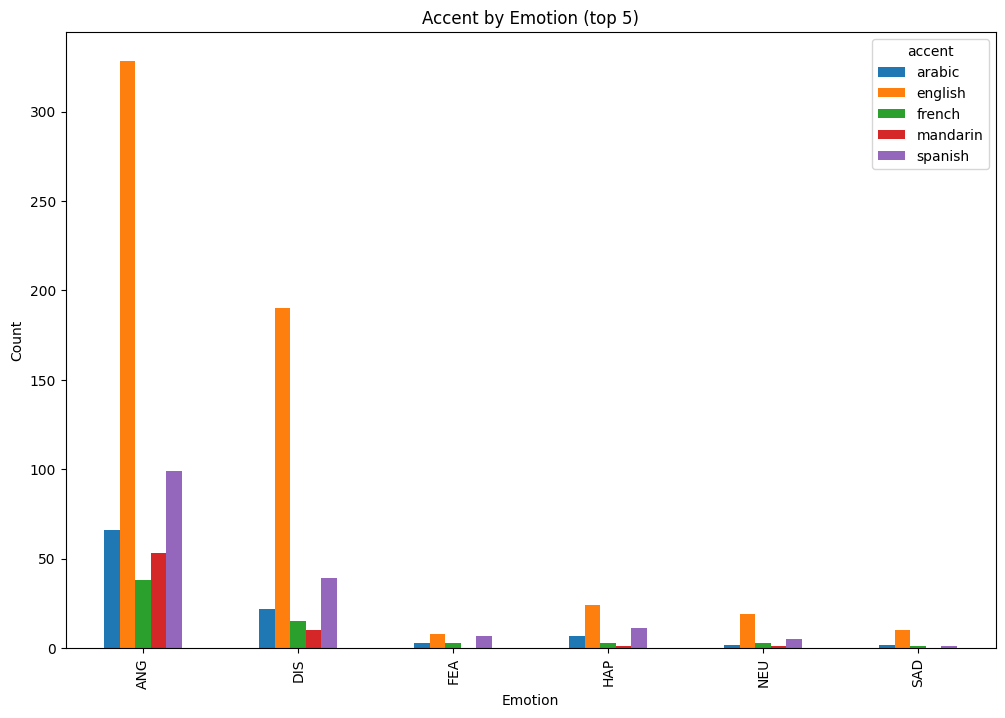

In [154]:
plt.figure()
filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

<Figure size 640x480 with 0 Axes>

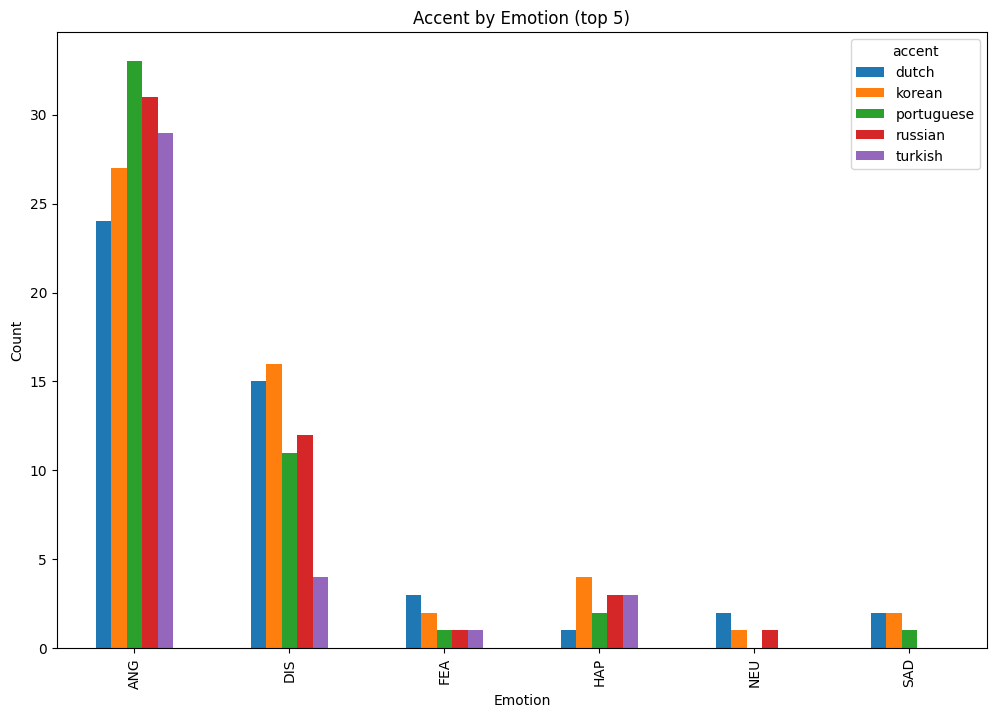

In [155]:
plt.figure()
filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [148]:
top_relative_df = filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack()
next_relative_df = filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack()

for row in range(len(top_relative_df)):
  for accent in accents_by_count_top_five:
    for emotion in emotions_list:
      column_sum = top_relative_df[accent].sum()
      top_relative_df.loc[emotion, accent] = (top_relative_df.loc[emotion, accent] / column_sum) * 100

for row in range(len(next_relative_df)):
  for accent in accents_by_count_next_five:
    for emotion in emotions_list:
      column_sum = next_relative_df[accent].sum()
      next_relative_df.loc[emotion, accent] = (next_relative_df.loc[emotion, accent] / column_sum) * 100

In [150]:
next_relative_df

accent,dutch,korean,portuguese,russian,turkish
crema-d predictions,,,,,
ANG,67.023680,65.742944,81.643361,78.492287,90.648111
DIS,22.243297,22.619819,13.576366,15.371223,4.697796
FEA,4.067869,2.611185,1.198113,1.231348,1.165144
HAP,1.338711,5.185096,2.390826,3.684195,3.488886
NEU,2.666628,1.278507,NaN,1.218441,NaN
SAD,2.645589,2.548775,1.190116,NaN,NaN


<Figure size 640x480 with 0 Axes>

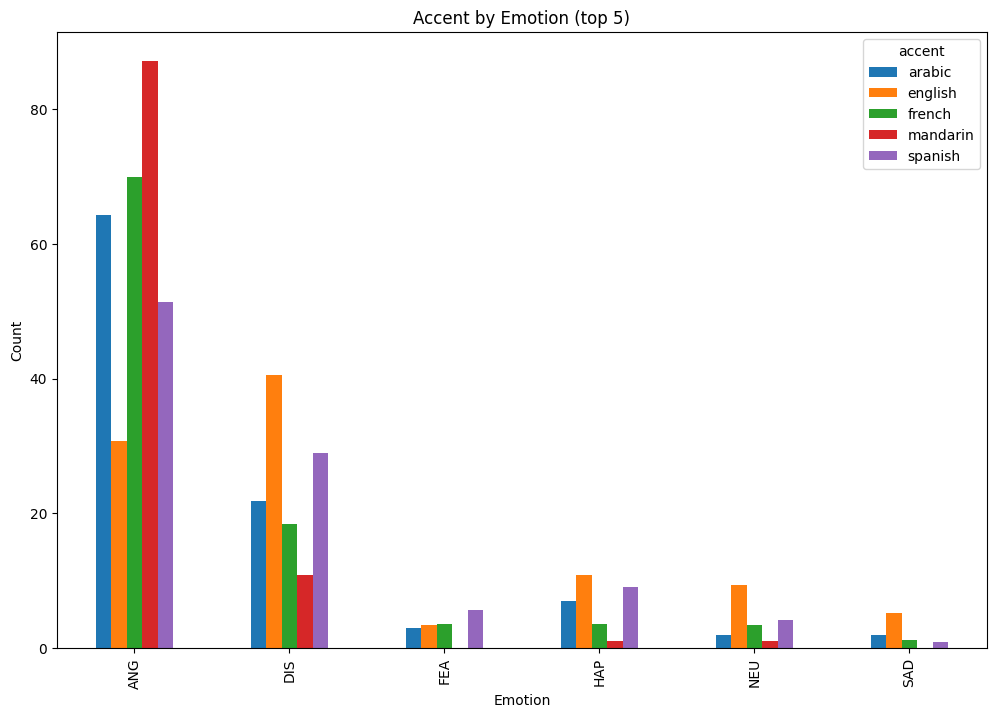

In [152]:
plt.figure()
top_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

<Figure size 640x480 with 0 Axes>

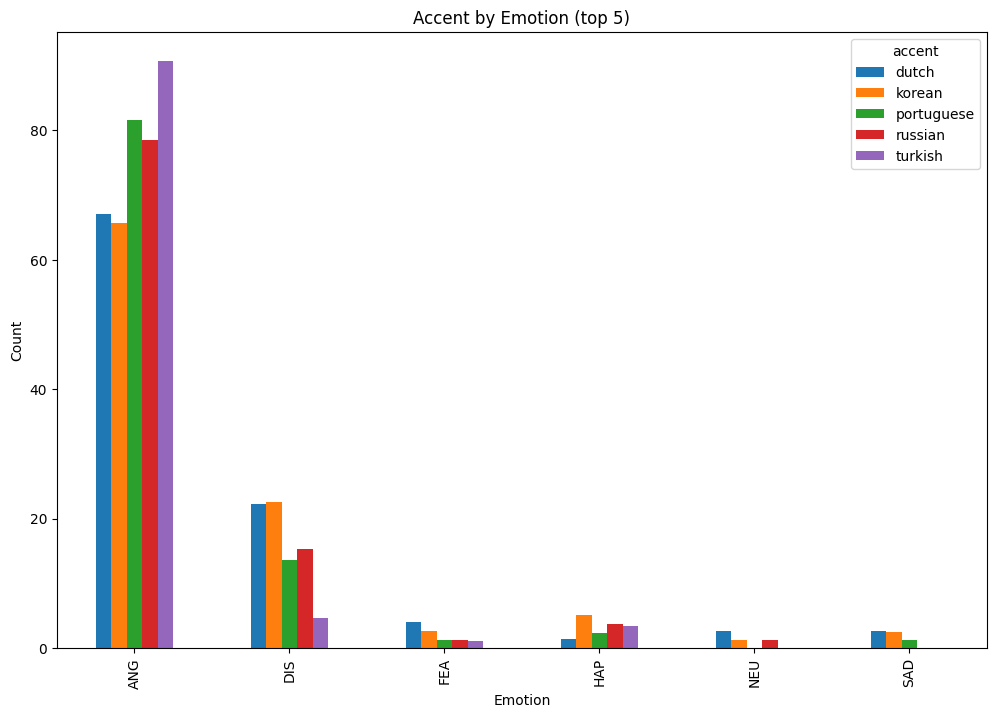

In [153]:
plt.figure()
next_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

## Experiment 2
**Importing the HugginFace Model**

In [ ]:
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
import librosa
import torch
import numpy as np

model_id = "firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3"
model = AutoModelForAudioClassification.from_pretrained(model_id)

feature_extractor = AutoFeatureExtractor.from_pretrained(model_id, do_normalize=True)
id2label = model.config.id2label

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
def preprocess_audio(audio_path, feature_extractor, max_duration=30.0):
    audio_array, sampling_rate = librosa.load(audio_path, sr=None)

    max_length = int(feature_extractor.sampling_rate * max_duration)
    if len(audio_array) > max_length:
        audio_array = audio_array[:max_length]
    else:
        audio_array = np.pad(audio_array, (0, max_length - len(audio_array)))

    inputs = feature_extractor(
        audio_array,
        sampling_rate=feature_extractor.sampling_rate,
        return_tensors="tf",
    )
    return inputs

In [ ]:
def predict_emotion(audio_path, model, feature_extractor, id2label, max_duration=30.0):
    inputs = preprocess_audio(audio_path, feature_extractor, max_duration)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_id = torch.argmax(logits, dim=-1).item()
    predicted_label = id2label[predicted_id]

    return predicted_label

**Base model predictions**

In [ ]:
path_prefix_ssa = "/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings/"

for file_row in range(len(ssa_df)):
  emotion_prediction = predict_emotion((path_prefix_ssa + ssa_df.loc[file_row, 'path']), model, feature_extractor, id2label)
  ssa_df.loc[file_row, 'firdhokk predictions'] = emotion_prediction

ssa_df

,path,accent,number,crema d predictions,crema-d predictions,firdhokk predictions
0,spanish28.mp3,spanish,28,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,sad
1,german7.mp3,german,7,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,neutral
2,kanuri1.mp3,kanuri,1,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,fearful
3,english262.mp3,english,262,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,sad
4,polish13.mp3,polish,13,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,neutral
...,...,...,...,...,...,...
2133,english546.mp3,english,546,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",HAP,sad
2134,german8.mp3,german,8,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,neutral
2135,english88.mp3,english,88,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,angry
2136,spanish100.mp3,spanish,100,"[ANG, ANG, ANG, ANG, ANG, ANG, ANG, ANG, HAP, ...",ANG,happy


**Transfer Learning**

In [ ]:
model.trainable = False

transfer_learning_input = keras.layers.Input(shape=(None, extracted_features_padded.shape[2]))
transfer_learning_base_model = model(transfer_learning_input)
transfer_learning_dense = keras.layers.Dense(100, kernel_regularizer=regularizers.l2(), activation="relu")(transfer_learning_base_model)
transfer_learning_output = keras.layers.Dense(ssa_df['firdhokk predictions'].nunique(), activation="softmax")(transfer_learning_dense)


new_model = keras.Model(inputs=transfer_learning_input, outputs=transfer_learning_output)

ValueError: Whisper expects the mel input features to be of length 3000, but found 40. Make sure to pad the input mel features to 3000.

In [ ]:
new_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.CategoricalCrossentropy(),
  metrics = [keras.metrics.CategoricalAccuracy()]
)

NameError: name 'new_model' is not defined

In [ ]:
new_model.fit(X, y, validation_split=0.2, epochs=40, batch_size=15, shuffle=True, callbacks=[early_stopping_callback])